<a href="https://colab.research.google.com/github/bungerz/firstDataAnalysis/blob/master/Hackathon_AI_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [7]:
!unzip HDLTex\ dataset-20250508.zip -d HDLTex
!unzip fMRI\ dataset-20250508.zip -d fMRI

!pip install wfdb
!pip install pandas==2.2.2

Archive:  HDLTex dataset-20250508.zip
  inflating: HDLTex/Dictionary.txt   
  inflating: HDLTex/HLDTex.pdf       
  inflating: HDLTex/ReadMe.txt       
  inflating: HDLTex/Meta-data/Data.xlsx  
  inflating: HDLTex/WOS11967/X.txt   
  inflating: HDLTex/WOS11967/Y.txt   
  inflating: HDLTex/WOS11967/YL1.txt  
  inflating: HDLTex/WOS11967/YL2.txt  
  inflating: HDLTex/WOS46985/X.txt   
  inflating: HDLTex/WOS46985/Y.txt   
  inflating: HDLTex/WOS46985/YL1.txt  
  inflating: HDLTex/WOS46985/YL2.txt  
  inflating: HDLTex/WOS5736/X.txt    
  inflating: HDLTex/WOS5736/Y.txt    
  inflating: HDLTex/WOS5736/YL1.txt  
  inflating: HDLTex/WOS5736/YL2.txt  
Archive:  fMRI dataset-20250508.zip
replace fMRI/centralities_with_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fMRI/centralities_with_labels.csv  
replace fMRI/Table_ADNI.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fMRI/Table_ADNI.csv     


In [2]:
#!wget -r -np -nH --cut-dirs=4 -R "index.html*" -P physionet https://physionet.org/files/challenge-2020/1.0.2/training/cpsc_2018/
import kagglehub
# Download latest version
physionet_path = kagglehub.dataset_download("bjoernjostein/china-physiological-signal-challenge-in-2018")
physionet_path += "/Training_WFDB"
print("Path to dataset files:", physionet_path)
# Download latest version
ecg_snomed_path = kagglehub.dataset_download("bjoernjostein/physionet-snomed-mappings")
print("Path to dataset files:", ecg_snomed_path)

100%|██████████| 824M/824M [00:21<00:00, 39.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB


100%|██████████| 3.37k/3.37k [00:00<00:00, 6.41MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/bjoernjostein/physionet-snomed-mappings/versions/3


The disease associated with each patient is coded in snomed. Snomed is a terminology to represent clinical related concepts. You can search each term in this [browser](https://browser.ihtsdotools.org/?perspective=full&conceptId1=404684003&edition=MAIN/2023-03-31&release=&languages=en) to get more information about the disease corresponding to a given code.

In [3]:
dx_dict = {
    "426783006": "SNR",  # Normal sinus rhythm
    "164889003": "AF",  # Atrial fibrillation
    "270492004": "IAVB",  # First-degree atrioventricular block
    "164909002": "LBBB",  # Left bundle branch block
    "713427006": "RBBB",  # Complete right bundle branch block
    "59118001": "RBBB",  # Right bundle branch block
    "284470004": "PAC",  # Premature atrial contraction
    "63593006": "PAC",  # Supraventricular premature beats
    "164884008": "PVC",  # Ventricular ectopics
    "429622005": "STD",  # ST-segment depression
    "164931005": "STE",  # ST-segment elevation
}

In [4]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import wfdb
import os

# Quick exploration

## fmri

In [8]:
fmri_adni = pl.read_csv('fMRI/Table_ADNI.csv')
fmri_centrality = pl.read_csv('fMRI/centralities_with_labels.csv')
# fmri_adni_subject = fmri_adni.filter((pl.col('Age')==63) & (pl.col('Sex')=='F'))
# fmri_adni_peers = fmri_adni.filter((pl.col('Age') > 55) & (pl.col('Age') <  70) & (pl.col('Sex')=='F'))
# display(fmri_adni_subject)
# display(fmri_adni_peers)
# groups is illness, subgroups of neurodegenerative disease
# MCI: mild cognitive imperment
fmri_adni

Subject,Group,RID,Sex,Code_sex,Age,APGEN1,APGEN2,PTEDUCAT,MMSE,CDR,NPI,GDSCALE,E4,E2,E3
str,str,i64,str,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64
"""037_S_0150""","""MCI""",150,"""M""",1,86,3,3,12,27,0.5,4,1,0,0,1
"""002_S_0413""","""CN""",413,"""F""",2,87,3,3,16,29,0.0,0,0,0,0,1
"""032_S_0677""","""CN""",677,"""M""",1,82,3,3,18,28,0.0,0,0,0,0,1
"""041_S_0679""","""MCI""",679,"""M""",1,74,3,3,18,29,0.5,3,0,0,0,1
"""068_S_0802""","""MCI""",802,"""F""",2,92,3,3,8,26,0.5,7,2,0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""082_S_6690""","""AD""",6690,"""F""",2,68,3,4,14,20,1.0,4,1,1,0,0
"""041_S_6731""","""MCI""",6731,"""F""",2,67,3,4,20,27,0.5,1,3,1,0,0
"""011_S_4827""","""AD""",4827,"""M""",1,76,2,4,18,26,0.5,13,1,1,1,0


### PCA for fmri

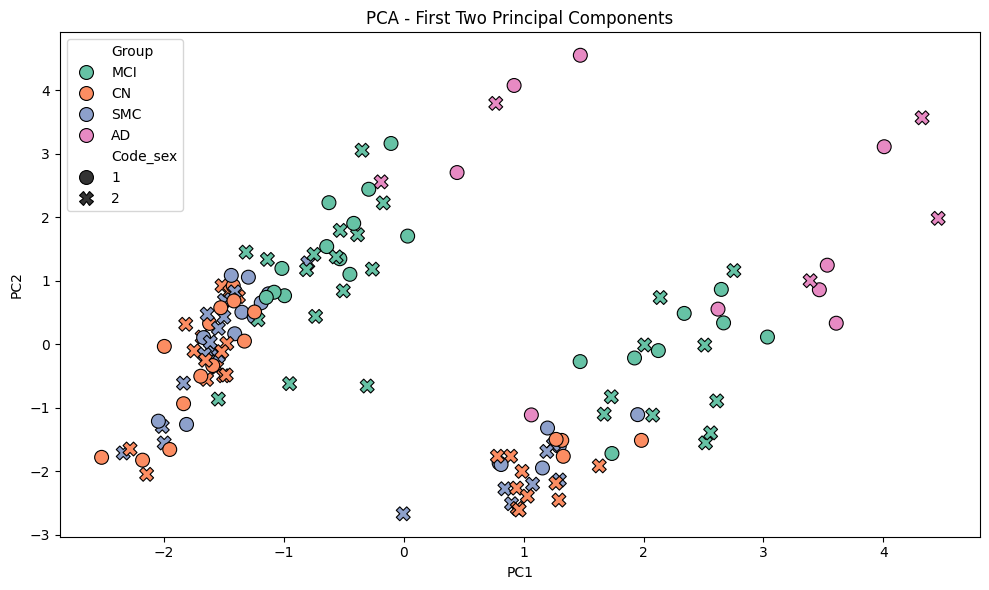

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming fmri_adni is your original DataFrame
df_pandas = fmri_adni.to_pandas()

# Step 2: Select relevant columns for PCA (excluding Subject, Group, RID, Sex)
features = df_pandas.drop(columns=["Subject", "Group", "RID", "Sex"])

# Step 3: Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 4: Apply PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Step 5: Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])

# Step 6: Add Group and Code_sex for coloring and symbol purposes
pca_df["Group"] = df_pandas["Group"]
pca_df["Code_sex"] = df_pandas["Code_sex"]

# Step 7: Visualize the first two principal components with color by Group and symbol by Code_sex
plt.figure(figsize=(10, 6))

# Define a list of markers based on Code_sex (assuming Code_sex contains categorical values like 0 and 1)
markers = {0: 'o', 1: 's'}  # 'o' for male (Code_sex=0), 's' for female (Code_sex=1)

# Use sns.scatterplot with style parameter for different markers based on Code_sex
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Group",
    style="Code_sex",  # Map marker styles to Code_sex
    palette="Set2",    # Color palette for Group
    s=100,
    edgecolor='black'
)

plt.title('PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show the plot
plt.tight_layout()
plt.show()

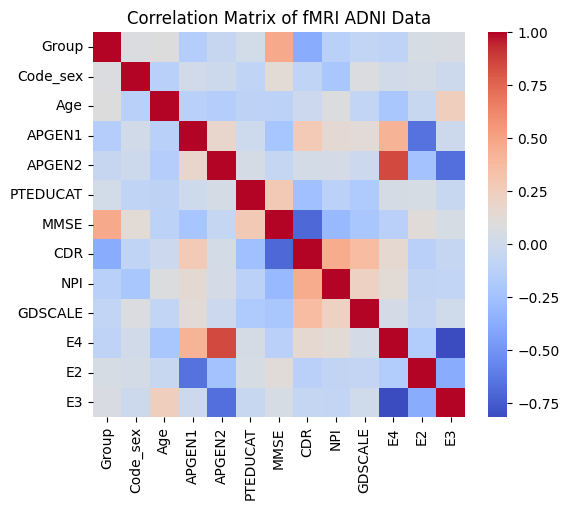

In [10]:
# prompt: from frmi_adni compute the correlation matrix, do not exclude the Group feature but put it as a numerical feature

# Assuming fmri_adni is your DataFrame from the previous code
# Convert 'Group' to numerical representation if it's categorical
# Example using Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_pandas['Group'] = le.fit_transform(df_pandas['Group'])

# Select all columns except 'Subject' and 'RID' for correlation calculation
correlation_matrix = df_pandas.drop(columns=["Subject", "RID",'Sex']).corr()

# Display the correlation matrix
# print(correlation_matrix)

# You can visualize the correlation matrix using a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Correlation Matrix of fMRI ADNI Data")
plt.show()


In [ ]:
# case_data = fmri_centrality.filter(pl.col.Subject == fmri_adni_subject[0]['Subject']).drop("Subject")
# peers_data = fmri_centrality.filter(pl.col.Subject.is_in(fmri_adni_peers['Subject'].explode())).drop("Subject")
# fmri_centrality.describe()

In [ ]:
# # Calculate Z-scores for the case patient
# peer_means = peers_data.mean()
# peer_stds = peers_data.std()
# z_scores = (case_data - peer_means) / peer_stds
# z_scores
# case_data.columns
# # Visualization
# z_df = z_scores.unpivot()
# plt.figure(figsize=(10, 5))
# sns.barplot(x="variable", y="value", data=z_df)
# plt.axhline(0, color="gray", linestyle="--")
# plt.title("fMRI Centrality Z-Scores for Case Patient")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig("fmri_zscores.png")
# plt.show()

## ECG

In [20]:
import glob
all_ecg_paths = glob.glob(os.path.join(physionet_path,'*.hea'))
ecg_patients = [path.split('/')[-1].split('.')[0].replace('A','HR0') for path in all_ecg_paths]
ecg_ref = pl.read_csv("reference.csv",null_values=['NaN'])
ecg_labels = pl.read_csv("labels.csv",null_values=['NaN'])
ecg_labels = ecg_labels.filter(pl.col.patient_id.is_in(ecg_patients))
ecg_ref = ecg_ref.filter(pl.col.patient_id.is_in(ecg_patients))
ecg_labels.group_by('set').agg(pl.col.SNR.count())
# ecg_ref
# ecg_patients

['/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB/A5297.hea',
 '/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB/A3037.hea',
 '/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB/A4173.hea',
 '/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB/A4506.hea',
 '/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB/A3511.hea',
 '/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB/A1356.hea',
 '/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018/versions/1/Training_WFDB/A3618.hea',
 '/root/.cache/kagglehub/datasets/bjoernjostein/china-physiological-signal-challenge-in-20

quick print of one ECG

The signal has 11000 timesteps and 12 leads


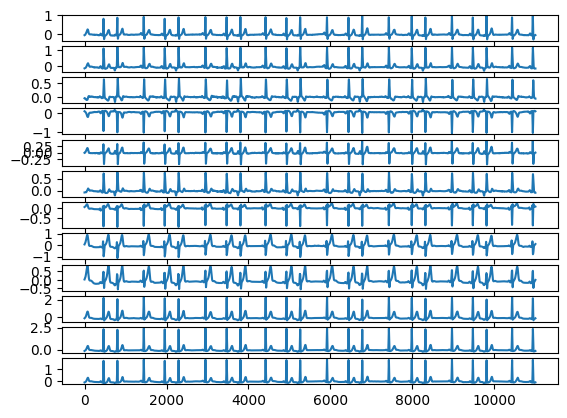

In [13]:
path_signal = os.path.join(physionet_path, "A0500" )
signal, metadata = wfdb.rdsamp(path_signal)
print(f"The signal has {signal.shape[0]} timesteps and {signal.shape[1]} leads")
fig, axs = plt.subplots(signal.shape[1])
for idx in range(signal.shape[1]):
    axs[idx].plot(signal[:,idx])
plt.show()

ecg Snomed mapping

In [14]:
snomed_csv_paths = glob.glob(os.path.join(ecg_snomed_path,'**.csv'))
#glob.glob(os.path.join(an_ecg_path,'**/*.hea'))

import glob
ecg_snomed0 = pl.read_csv(snomed_csv_paths[0],separator=';').select(["Dx",pl.col("SNOMED CT Code").cast(pl.String),"Abbreviation","CPSC"])
ecg_snomed1 = pl.read_csv(snomed_csv_paths[1],separator=';').select(["Dx",pl.col("SNOMED CT Code").cast(pl.String),"Abbreviation","CPSC"])
# ecg_snomed0 = ecg_snomed0.filter(pl.col.CPSC != 0)
# ecg_snomed1 = ecg_snomed1.filter(pl.col.CPSC != 0)

ecg_snomed = pl.concat([ecg_snomed0,ecg_snomed1])
ecg_snomed

Dx,SNOMED CT Code,Abbreviation,CPSC
str,str,str,i64
"""1st degree av block""","""270492004""","""IAVB""",722
"""atrial fibrillation""","""164889003""","""AF""",1221
"""atrial flutter""","""164890007""","""AFL""",0
"""bradycardia""","""426627000""","""Brady""",0
"""complete right bundle branch b…","""713427006""","""CRBBB""",0
…,…,…,…
"""ventricular pre excitation""","""195060002""","""VPEx""",0
"""ventricular tachycardia""","""164895002""","""VTach""",0
"""ventricular trigeminy""","""251180001""","""VTrig""",0


# Training Models

## ECG

patient to disease list

In [15]:
def assign_random_age(age):
    if age >= 300:
        # Generate a random value between 89 and 100 using an exponential distribution
        random_age = np.random.exponential(scale=5) + 89
        # Ensure that the random age is in the desired range
        return min(max(int(random_age), 89), 100)
    return age

# Step 1: Split the 'dx' column in `ecg_ref` into lists of codes
ecg_ref_split = ecg_ref.with_columns(
    pl.col("dx").str.split(",").alias("dx_split")
)

# Step 2: Explode the list of disease codes into separate rows
ecg_ref_exploded = ecg_ref_split.explode("dx_split")

# Step 3: Perform a left join to map the disease codes to disease names
joined_df = ecg_ref_exploded.join(ecg_snomed, left_on="dx_split", right_on="SNOMED CT Code", how="left")

# Step 4: Group back by 'patient_id' to get the disease names for each patient
final_df = joined_df.group_by("patient_id").agg(
    pl.col("Abbreviation").alias("disease_names"),
    pl.col("age").first(),
    pl.col("sex").first(),
).with_columns(
    pl.col("age").map_elements(assign_random_age).alias("age")
)
final_df

<ipython-input-15-8f7b15dcfe6d>:25: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  ).with_columns(


patient_id,disease_names,age,sex
str,list[str],i64,str
"""HR04167""","[""SNR"", ""LAE"", ""NSIVCB""]",66,"""Female"""
"""HR03167""","[""SNR""]",46,"""Male"""
"""HR00210""","[""MI"", ""LAD"", ""SNR""]",58,"""Male"""
"""HR00509""","[""SNR""]",40,"""Female"""
"""HR01245""","[""LAD"", ""SNR""]",53,"""Male"""
…,…,…,…
"""HR00697""","[""LVH"", ""AF"", ""ICA""]",69,"""Male"""
"""HR01907""","[""MI"", ""QAb"", … ""CRBBB""]",87,"""Male"""
"""HR02206""","[""MI"", ""TAb"", … ""STD""]",83,"""Male"""


### ECG: Disease by Age

<ipython-input-16-46400c1bc1ce>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_exploded, x="age", multiple="stack", palette='Set2', bins=30)


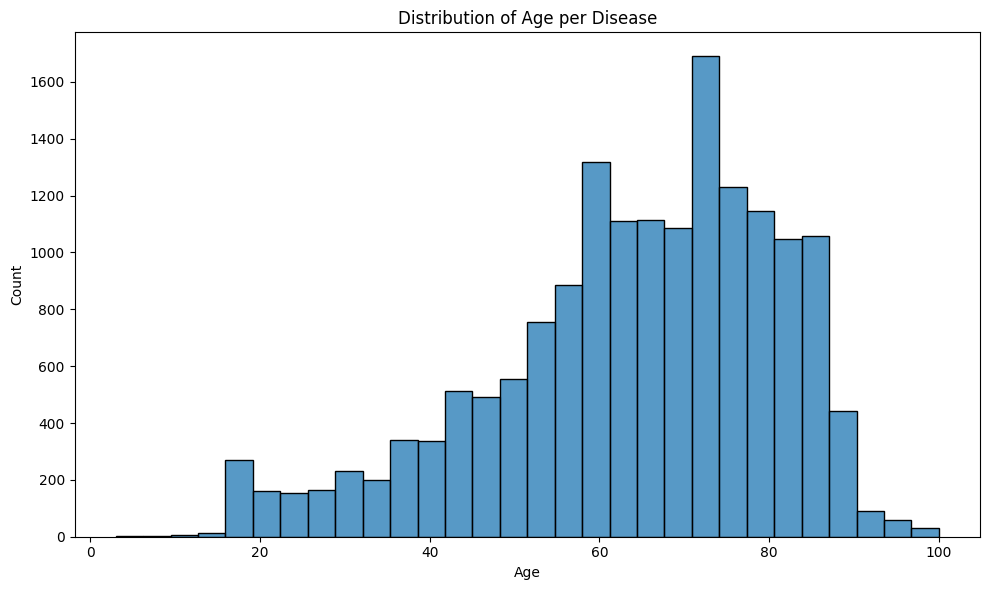

In [16]:

# Step 3: Explode the disease_names list into separate rows
df_exploded = final_df.to_pandas().explode('disease_names')

# Step 4: Reset the index to avoid index duplication issues
df_exploded = df_exploded.reset_index(drop=True)

# Step 5: Plot the distribution of Age per Disease
plt.figure(figsize=(10, 6))

# Plot histograms for Age per disease
sns.histplot(data=df_exploded, x="age", multiple="stack", palette='Set2', bins=30)

# Set the plot title and labels
plt.title('Distribution of Age per Disease')
plt.xlabel('Age')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()


adding multihot

In [17]:
import polars as pl
import numpy as np

# Assuming `final_df` is your DataFrame with the `patient_id` and `disease_names`

# Step 1: Get the list of unique diseases and create a dictionary that maps disease names to indices
unique_diseases = set([disease for disease_list in final_df["disease_names"] for disease in disease_list])
disease_to_index = {disease: idx for idx, disease in enumerate(sorted(unique_diseases))}

# Print disease to index mapping for reference
print(disease_to_index)

# Step 2: Generate Multi-Hot Encoding for each patient
def generate_multi_hot(disease_names, disease_to_index):
    # Create a binary vector (multi-hot encoding)
    multi_hot = np.zeros(len(disease_to_index), dtype=int)
    for disease in disease_names:
        if disease in disease_to_index:
            multi_hot[disease_to_index[disease]] = 1
    return multi_hot

# Step 3: Apply the multi-hot encoding to the 'disease_names' column
multi_hot_vectors = [
    generate_multi_hot(disease_names, disease_to_index)
    for disease_names in final_df["disease_names"]
]

# Step 4: Add the multi-hot encoding column to the DataFrame
final_df = final_df.with_columns(
    pl.DataFrame({"multi_hot": multi_hot_vectors})
)

final_df

{'AF': 0, 'AFL': 1, 'AnMI': 2, 'AnMIs': 3, 'CHB': 4, 'CRBBB': 5, 'IAVB': 6, 'ICA': 7, 'IIAVB': 8, 'IIs': 9, 'ILBBB': 10, 'IRBBB': 11, 'LAD': 12, 'LAE': 13, 'LAnFB': 14, 'LBBB': 15, 'LIs': 16, 'LPFB': 17, 'LPR': 18, 'LQRSV': 19, 'LQT': 20, 'LVH': 21, 'MI': 22, 'MIs': 23, 'NSIVCB': 24, 'NSSTTA': 25, 'PAC': 26, 'PR': 27, 'PSVT': 28, 'QAb': 29, 'RAD': 30, 'RAH': 31, 'RVH': 32, 'SA': 33, 'SB': 34, 'SNR': 35, 'STC': 36, 'STD': 37, 'STE': 38, 'STach': 39, 'SVPB': 40, 'SVT': 41, 'TAb': 42, 'TInv': 43, 'VBig': 44, 'VEB': 45, 'VH': 46, 'VTrig': 47, 'WPW': 48, 'abQRS': 49}


patient_id,disease_names,age,sex,multi_hot
str,list[str],i64,str,"array[i64, 50]"
"""HR04167""","[""SNR"", ""LAE"", ""NSIVCB""]",66,"""Female""","[0, 0, … 0]"
"""HR03167""","[""SNR""]",46,"""Male""","[0, 0, … 0]"
"""HR00210""","[""MI"", ""LAD"", ""SNR""]",58,"""Male""","[0, 0, … 0]"
"""HR00509""","[""SNR""]",40,"""Female""","[0, 0, … 0]"
"""HR01245""","[""LAD"", ""SNR""]",53,"""Male""","[0, 0, … 0]"
…,…,…,…,…
"""HR00697""","[""LVH"", ""AF"", ""ICA""]",69,"""Male""","[1, 0, … 0]"
"""HR01907""","[""MI"", ""QAb"", … ""CRBBB""]",87,"""Male""","[0, 0, … 0]"
"""HR02206""","[""MI"", ""TAb"", … ""STD""]",83,"""Male""","[0, 0, … 0]"


In [42]:
# Step 1: Load ECG Data for each patient
X = np.mean(np.stack([np.array(wfdb.rdrecord(f'{fname.replace(".hea","")}').p_signal[:250]) for fname in all_ecg_paths]),axis=2)
X = (X - np.mean(X)) / np.std(X)
# Step 2: Prepare multi-hot encoded labels
y = np.array([patient for patient in final_df["multi_hot"]])

# Check the shape of X and y
print("Shape of ECG data X:", X.shape)  # Should be (num_samples, 1000, num_channels)
print("Shape of labels y:", y.shape)    # Should be (num_samples, num_diseases)


Shape of ECG data X: (6877, 250)
Shape of labels y: (6877, 50)


In [43]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define model parameters
num_timesteps = X.shape[1]  # 1000 time steps
num_channels = 1  # As ECG is univariate, there is one channel (1 feature per time step)
num_classes = y.shape[1]  # 50 diseases

# Step 3: Build the LSTM model
model = Sequential([
    Input(shape=(num_timesteps, num_channels)),  # Correct input shape (1000, 1)
    LSTM(64, return_sequences=True),  # First LSTM layer
    Dropout(0.3),
    LSTM(32),  # Second LSTM layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='sigmoid')  # Output layer for multi-label classification (sigmoid)
])

# Step 4: Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # binary_crossentropy for multi-label classification
    metrics=['accuracy']
)

# Step 5: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # You can increase this based on your dataset size
    batch_size=32,  # Tune this based on your available resources (try smaller or larger)
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]  # Early stopping to prevent overfitting
)

# Optional: Save the trained model
model.save("ecg_lstm_model.h5")


Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2039 - loss: 0.3828 - val_accuracy: 0.4179 - val_loss: 0.1338
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4095 - loss: 0.1331 - val_accuracy: 0.4179 - val_loss: 0.1246
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4143 - loss: 0.1346 - val_accuracy: 0.4179 - val_loss: 0.1251
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4107 - loss: 0.1341 - val_accuracy: 0.4179 - val_loss: 0.1244
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4079 - loss: 0.1334 - val_accuracy: 0.4179 - val_loss: 0.1250
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4169 - loss: 0.1317 - val_accuracy: 0.4179 - val_loss: 0.1243
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4291 - loss: 0.1289 - val_accuracy: 0.4179 - val_loss: 0.1249
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4103 - loss: 0.1318 - val_accu

In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")

y_pred = model.predict(X_val)

## fMRI

### Disease by Age (nice one Mina :) )

In [ ]:
# Step 3: Plot the distribution of Age per Group using histplot
plt.figure(figsize=(10, 6))

# Use histplot with a categorical `hue` to differentiate groups
sns.histplot(data=fmri_adni, x="Age", hue="Group", kde=True, multiple="stack", palette='Set2', bins=30)

# Optional: You can use kde=False to remove the KDE (Kernel Density Estimate) curve
# sns.histplot(data=df_pandas, x="Age", hue="Group", kde=False, multiple="stack", palette='Set2', bins=30)

# Set the plot title and labels
plt.title('Distribution of Age per Group')
plt.xlabel('Age')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Step 3: Plot the distribution of Age per Group using histplot
plt.figure(figsize=(10, 6))

# Use histplot with a categorical `hue` to differentiate groups
sns.histplot(data=fmri_adni, x="Age", hue="Group", kde=True, multiple="stack", palette='Set2', bins=30)

# Optional: You can use kde=False to remove the KDE (Kernel Density Estimate) curve
# sns.histplot(data=df_pandas, x="Age", hue="Group", kde=False, multiple="stack", palette='Set2', bins=30)

# Set the plot title and labels
plt.title('Distribution of Age per Group')
plt.xlabel('Age')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()